# Diving Deeper into RSA

In this practical, you will estimate Representational Dissimilarity Matricies (RDMs) from data, compare them to each other, and experiment on different distance/similarity metrics. The tutorial part in the beginning is a condensed version of a demo from the rsatoolbox documentation ;)

In [15]:
# relevant imports
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import rsatoolbox
import rsatoolbox.data as rsd # abbreviation to deal with dataset
import rsatoolbox.rdm as rsr
%matplotlib inline

We first generate an example dataset we want to calculate RDM(s) from. We use simulated data for a 92 image dataset.

In [16]:
# create a dataset object
measurements = io.matlab.loadmat('data/simTruePatterns.mat')
measurements = measurements['simTruePatterns2']
nCond = measurements.shape[0]
nVox = measurements.shape[1]

# now create a  dataset object
des = {'session': 1, 'subj': 1}
obs_des = {'conds': np.array(['cond_%02d' % x for x in np.arange(nCond)])}
chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
data = rsd.Dataset(measurements=measurements,
                   descriptors=des,
                   obs_descriptors=obs_des,
                   channel_descriptors=chn_des)

### Calculating our first RDM
The main function to calculate RDMs from data is `rsatoolbox.rdm.calc_rdm` to which we have abbreviated access as `rsr.calc_rdm` here. The function takes a dataset object as its main input. Additionally, we here pass the descriptor 'conds' to specify that we want to create a RDM of dissimilarities between conditions as specified by 'conds'. If this input is not provided the RDM is calculated assuming that each row is a separate pattern or condition. To avoid confusion, we generally recommend to pass the `descriptor` argument.

In [17]:
# calculate a RDM
RDM_euc = rsr.calc_rdm(data, descriptor='conds')
print(RDM_euc)

rsatoolbox.rdm.RDMs
1 RDM(s) over 92 conditions

dissimilarity_measure = 
squared euclidean

dissimilarities[0] = 
[[0.         1.79168033 1.79025977 ... 2.34585297 2.34306615 2.37794181]
 [1.79168033 0.         1.82424097 ... 2.3153871  2.28580169 2.32155829]
 [1.79025977 1.82424097 0.         ... 2.40876617 2.36854597 2.32501722]
 ...
 [2.34585297 2.3153871  2.40876617 ... 0.         1.76469464 1.72393365]
 [2.34306615 2.28580169 2.36854597 ... 1.76469464 0.         1.78983719]
 [2.37794181 2.32155829 2.32501722 ... 1.72393365 1.78983719 0.        ]]

descriptors: 

rdm_descriptors: 
session = [1]
subj = [1]
index = [0]

pattern_descriptors: 
conds = [np.str_('cond_00'), np.str_('cond_01'), np.str_('cond_02'), np.str_('cond_03'), np.str_('cond_04'), np.str_('cond_05'), np.str_('cond_06'), np.str_('cond_07'), np.str_('cond_08'), np.str_('cond_09'), np.str_('cond_10'), np.str_('cond_11'), np.str_('cond_12'), np.str_('cond_13'), np.str_('cond_14'), np.str_('cond_15'), np.str_('cond_16')

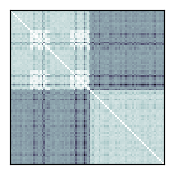

In [18]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(RDM_euc)

## Crossvalidated dissimilarities
When we have multiple independent measurements of a pattern we can use crossvalidated distances to achieve an unbiased estimate of the dissimilarities between patterns. Essentially, this is meant to counteract the upward bias caused by adding noise to the measurements. You may have noticed this bias by comparing the noisy RDMs we just created and the clean rdm we created at the beginning of this tutorial.

To illustrate how to do this using rsatoolbox, we first create a dataset with multiple (`n_rep`) measurements for each pattern:

In [19]:
n_rep = 3
m_noisy = np.repeat(measurements, n_rep, axis=0)
m_noisy += np.random.randn(*m_noisy.shape)
    
conds = np.array(['cond_%02d' % x for x in np.arange(nCond)])
sessions = np.tile(np.arange(n_rep), 92)
conds = np.repeat(conds, n_rep)
cv_obs_des = {'conds': conds, 'sessions': sessions}

des = {'subj': 1}

dataset = rsd.Dataset(
    measurements=m_noisy,
    descriptors=des,
    obs_descriptors=cv_obs_des,
    channel_descriptors=chn_des)

Importantly, we added a sessions descriptor which marks which measurement comes from which session. We can now compute the crossvalidated distances simply using the `'crossnobis'` rdm calculation method. To specify which measurements come from the same session we pass `'sessions'` as the `cv_descriptor`. 

In [20]:
rdm_cv = rsatoolbox.rdm.calc_rdm(dataset, method='crossnobis', descriptor='conds', cv_descriptor='sessions')

/Users/weidler/miniconda3/envs/ken3170/lib/python3.11/site-packages/numpy/_core/numeric.py:476: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


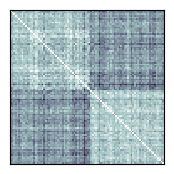

In [21]:
rsatoolbox.vis.show_rdm(rdm_cv)
None

Looking at this rdm, we can see that this indeed removed the overall upward bias, although the rdm is still noisy of course.

## Comparing RDMs

Once we have estimated RDMs from data, we can compare them to each other or to model RDMs. This is done using the `rsatoolbox.rdm.compare_rdm` function. Let's compare the crossvalidated RDM we just created to the clean RDM we created at the beginning of this tutorial:




In [22]:
rsatoolbox.rdm.compare(rdm_cv, RDM_euc, method='corr')

array([[0.78253809]])

#### Exercise I: Comparing different similarity measures

By reusing the code from above with which we created RDMs crossvalidated over multiple sessions, build a comparison of the different available similarity measures in the rsatoolbox and how they respond to different levels of noise. Plot the results with incremental levels of noise on the x-Axis, and the similarity between the noisy crossvalidated RDM and the true RDM on the y-Axis. 

In [23]:
# your code here

#### Optional Exercise: Also play with the RDM distance metric 

Do the above for the different distance metrics available (one plot for each).

In [24]:
# your code here

### Exercise II: Let's t-SNE this

Take the RDMs and plot them on a two-dimensional plane using t-SNE. Again do this for different noise levels and observe the effect of the noise. If you have the time, consider other methods, like UMAP (not discussed in class but available in sklearn).

In [25]:
# your code here

### Exercise III: Testing Hypotheses

Its time to make some ... hypotheses. The RDMs describe the dissimlarity between the images according to the representations recorded in the data. We can build model RDMs by hand that capture our assumptions about how similar or dissimilar the pictures should be if the brain representations discern the stimuli on certain features. Create such model RDMs by hand for certain assumptions about the images as you inspect them. Take the construction of a 'all-is-dissimilar' RDM as a starting point. 

In [56]:
all_dissimilar = np.ones((92, 92)) + np.random.randn(92, 92) * 0.001
np.fill_diagonal(all_dissimilar, 0)
all_dissimilar = np.expand_dims(all_dissimilar, 0)
all_dissimilar_rdm = rsr.RDMs(all_dissimilar)

rsr.compare(RDM_euc, all_dissimilar_rdm, method='corr')

Now build at least two hypotheses yourself and capture them in an RDM. Check with hypothesis is closer to reality.

In [ ]:
# your code here